In [2]:
import os
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".png"):
                    full_path = os.path.join(root, file)
                    # Extraer etiqueta del nombre de la carpeta (positive/negative)
                    label = 1 if "positive" in root.lower() else 0
                    self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = MURABinaryDataset("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/data_sample/train", transform=transform)
valid_dataset = MURABinaryDataset("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/data_sample/valid", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [6]:
print(f"Total imágenes en train: {len(train_dataset)}")
print(f"Total imágenes en valid: {len(valid_dataset)}")

# Ejemplo visual
img, label = train_dataset[0]
print("Etiqueta:", label)
img.permute(1, 2, 0).numpy().shape  # solo para ver la imagen como tensor

Total imágenes en train: 12
Total imágenes en valid: 11
Etiqueta: 0


(224, 224, 3)

In [7]:
import torch
import torch.nn as nn
from torchvision import models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

resnet18 = models.resnet18(weights='DEFAULT')
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)  # 2 clases: [negative, positive]
resnet18 = resnet18.to(DEVICE)

In [9]:
from torch import optim
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    resnet18.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluación
    resnet18.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(resnet18.state_dict(), "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_binario.pt")
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping activado.")
            break

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Train Loss: 0.0916 | Val Loss: 0.5096 | Acc: 0.9091 | F1: 0.9231
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.0194 | Val Loss: 0.4530 | Acc: 0.8182 | F1: 0.8571
Mejor modelo guardado.
Epoch 3 | Train Loss: 0.0047 | Val Loss: 0.4114 | Acc: 0.8182 | F1: 0.8571
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.0021 | Val Loss: 0.3792 | Acc: 1.0000 | F1: 1.0000
Mejor modelo guardado.
Epoch 5 | Train Loss: 0.0012 | Val Loss: 0.3492 | Acc: 1.0000 | F1: 1.0000
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.0008 | Val Loss: 0.3191 | Acc: 1.0000 | F1: 1.0000
Mejor modelo guardado.
Epoch 7 | Train Loss: 0.0005 | Val Loss: 0.2948 | Acc: 1.0000 | F1: 1.0000
Mejor modelo guardado.
Epoch 8 | Train Loss: 0.0004 | Val Loss: 0.2784 | Acc: 1.0000 | F1: 1.0000
Mejor modelo guardado.
Epoch 9 | Train Loss: 0.0003 | Val Loss: 0.2736 | Acc: 1.0000 | F1: 1.0000
Mejor modelo guardado.
Epoch 10 | Train Loss: 0.0002 | Val Loss: 0.2791 | Acc: 0.9091 | F1: 0.9091



Reporte de Clasificación:
              precision    recall  f1-score   support

    negative       0.83      1.00      0.91         5
    positive       1.00      0.83      0.91         6

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



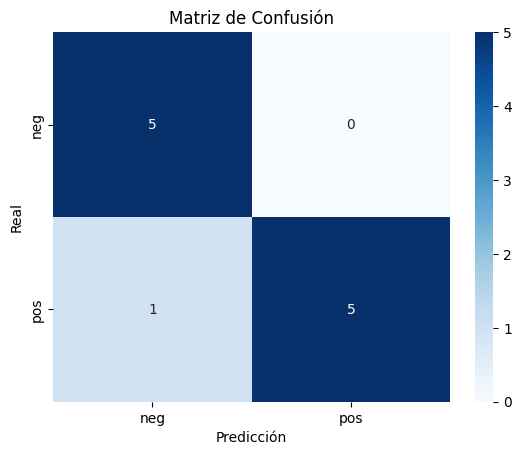

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()